## Predicated range delay from troposphere based on ERA5

+ ERA5
  - 0.25 deg spatial resolution
  - 1-hour temporal resolution

+ reference geometry:
  - use incidence angle, latitude and longitude of the scene center
  - use terrain height for vertical integration.

+ tropospheric components:
  - Dry troposphere: large absolute value with little variation
  - Wet troposphere: small absolute value with large  variation
  - comb (dry + wet) delay is used.

In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp, isce_utils
from mintpy import tropo_pyaps3
import pyaps3 as pa
figsize = [12, 4]

proj_dir = '/Users/yunjunz/data/ChileSenAT149'
os.chdir(proj_dir)
print('Go to directory', proj_dir)

mintpy_dir = os.path.join(proj_dir, 'mintpyOffset')
out_file = os.path.join(mintpy_dir, 'TS_era5.pickle')

Go to directory /Users/yunjunz/data/ChileSenAT149


### 1. calc tropo delay

In [3]:
# required input files
xml_file = os.path.join(proj_dir, 'reference/IW1.xml')
geom_file = os.path.join(mintpy_dir, 'inputs/geometryRadar.h5')
ts_file = os.path.join(mintpy_dir, 'timeseriesRg.h5')

# get scene center geometry
burst = isce_utils.extract_isce_metadata(xml_file)[1]
height = np.array(burst.terrainHeight).reshape(1,1)
print('terrain height: {} m'.format(height))

atr = readfile.read_attribute(ts_file)
len2 = int(int(atr['LENGTH']) / 2)
wid2 = int(int(atr['WIDTH']) / 2)
box = (wid2, len2, wid2+1, len2+1)
inc_angle = readfile.read(geom_file, datasetName='incidenceAngle', box=box)[0]
lat       = readfile.read(geom_file, datasetName='latitude',       box=box)[0]
lon       = readfile.read(geom_file, datasetName='longitude',      box=box)[0]

# get grib file names
model = 'ERA5'
snwe = tropo_pyaps3.get_snwe(atr)
grib_dir = os.path.join(os.path.expandvars('$WEATHER_DIR'), model)
date_list = timeseries(ts_file).get_date_list()
hour = tropo_pyaps3.closest_weather_model_hour(atr['CENTER_LINE_UTC'], grib_source=model)
grib_files = tropo_pyaps3.get_grib_filenames(date_list, hour, model, grib_dir, snwe)

# calculate delay using PyAPS
num_date = len(date_list)
tropo_delay = np.zeros((num_date, 3), dtype=np.float32)
prog_bar = ptime.progressBar(maxValue=num_date)
for i in range(num_date):
    for j, delay_type in enumerate(['comb', 'dry', 'wet']):
        aps_obj = pa.PyAPS(grib_files[i], grib=model, Del=delay_type,
                           dem=height, inc=inc_angle, lat=lat, lon=lon, verb=False)
        pha = np.zeros((aps_obj.ny, aps_obj.nx), dtype=np.float32)
        aps_obj.getdelay(pha)
        pha *= -1

        # save to matrix
        tropo_delay[i, j] = pha.flatten()
    prog_bar.update(i+1, suffix=date_list[i])
prog_bar.close()

extract metadata from ISCE/topsStack xml file: /Users/yunjunz/data/ChileSenAT149/reference/IW1.xml
terrain height: [[2176.]] m
[==================================================] 20200228  417s /     8s 


### 2. save to pickle file

In [5]:
## compose off dict
tropo = {}
tropo['date'] = np.array(date_list)
tropo['time'] = np.array(ptime.date_list2vector(date_list)[0])
tropo['range_delay_tropo']     = tropo_delay[:,0]
tropo['range_delay_tropo_dry'] = tropo_delay[:,1]
tropo['range_delay_tropo_wet'] = tropo_delay[:,2]

## save off dict to pickle file
with open(out_file, 'wb') as f:
    pickle.dump(tropo, f)
    print('save data to file: {}'.format(out_file))

save data to file: /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_era5.pickle


### 3. plot (variation between dry and wet troposphere)

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo_dry_wet.png


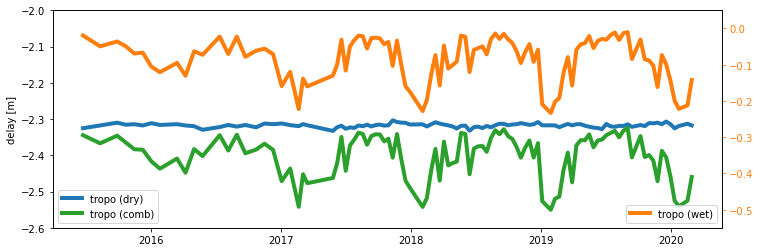

In [6]:
# plot
fig, ax = plt.subplots(figsize=figsize)
ax.plot(tropo['time'], tropo['range_delay_tropo_dry'], linewidth=4, color='C0', label='tropo (dry)')
ax.plot(tropo['time'], tropo['range_delay_tropo'],     linewidth=4, color='C2', label='tropo (comb)')
ax.set_ylabel('delay [m]')
ax.set_ylim(-2.6, -2.0)   #0.32
ax.legend(loc='lower left')

ax2 = ax.twinx()
ax2.plot(tropo['time'], tropo['range_delay_tropo_wet'],  linewidth=4, color=pp.mplColors[1], label='tropo (wet)')
ax2.tick_params(which='both', axis='y', colors=pp.mplColors[1])
ax2.set_ylim(-0.55, 0.05)  #0.32
ax2.legend(loc='lower right')

# output
out_fig = os.path.join(mintpy_dir, 'TS_tropo_dry_wet.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Obsolete: 1. Read from pre-calculated HDF5 files with real DEM.

In [7]:
ts_files = [
    os.path.join(mintpy_dir, 'inputs/ERA5.h5'),
    os.path.join(mintpy_dir, 'inputs/ERA5dry.h5'),
    os.path.join(mintpy_dir, 'inputs/ERA5wet.h5'),
]

# calculate absolute tropospheric delay from ERA5
for ts_file in ts_files:
    if not os.path.isfile(ts_file):
        os.chdir(mintpy_dir)
        !tropo_pyaps3.py -f timeseriesRg.h5 -g inputs/geometryRadar.h5
        os.chdir(proj_dir)

# read data
date_list = timeseries(ts_files[0]).get_date_list()
num_date = len(date_list)
atr = readfile.read_attribute(ts_files[0])
length, width = int(atr['LENGTH']), int(atr['WIDTH'])
ind_center = int(length / 2) * length + int(width / 2)

ts_comb = readfile.read(ts_files[0])[0].reshape(num_date, -1)
ts_dry  = readfile.read(ts_files[1])[0].reshape(num_date, -1)
ts_wet  = readfile.read(ts_files[2])[0].reshape(num_date, -1)

# calculate median and mean
tropo_med = np.nanmedian(ts_comb, axis=-1)
tropo_avg = np.nanmean(ts_comb, axis=-1)
tropo_cen = ts_comb[:, ind_center]

tropo_dry_med = np.nanmedian(ts_dry, axis=-1)
tropo_wet_med = np.nanmedian(ts_wet, axis=-1)

### Obsolete 2.1: plot variance between `median`, `mean` and `scene center`

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo.png


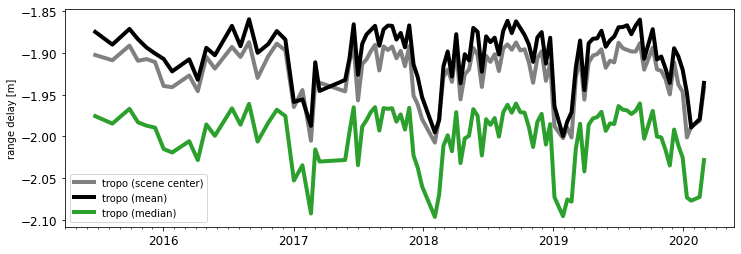

In [8]:
times = np.array(ptime.date_list2vector(date_list)[0])

fig, ax = plt.subplots(figsize=figsize)
ax.plot(times, tropo_cen, linewidth=4, color='gray', label='tropo (scene center)')
ax.plot(times, tropo_avg, linewidth=4, color='k',    label='tropo (mean)')
ax.plot(times, tropo_med, linewidth=4, color='C2',   label='tropo (median)')
pp.auto_adjust_xaxis_date(ax, times, every_year=1, buffer_year=None)
ax.set_ylabel('range delay [m]')
plt.legend()

# output
out_fig = os.path.join(mintpy_dir, 'TS_tropo.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### Obsolete 2.2: plot difference between `median-mean` and `median-center`

save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_tropo_diff.png


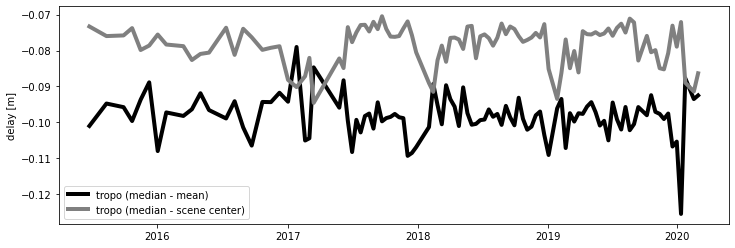

In [10]:
# plot median / mean / center difference
fig, ax = plt.subplots(figsize=figsize)
ax.plot(times, tropo_med - tropo_avg, linewidth=4, color='k',    label='tropo (median - mean)')
ax.plot(times, tropo_med - tropo_cen, linewidth=4, color='gray', label='tropo (median - scene center)')
ax.set_ylabel('delay [m]')
plt.legend()

# output
out_fig = os.path.join(mintpy_dir, 'TS_tropo_diff.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()